In [1]:
import torch.nn as nn
import torch
import pdb

import sys, os
import random
import numpy as np
from shutil import copy
import matplotlib.pyplot as plt
from copy import deepcopy

from omegaconf import OmegaConf
import shutil
import pickle
import random
from tqdm import tqdm
import torch.nn.functional as F
from collections import defaultdict

In [2]:
# run_path = '/home/harishbabu/projects/PIPNet/runs/010-CUB-27-imgnet_OOD_cnext26_img=224_nprotos=20'
# run_path = '/home/harishbabu/projects/PIPNet/runs/031-CUB-18-imgnet_cnext26_img=224_nprotos=20_orth-on-rel'
# run_path = '/home/harishbabu/projects/PIPNet/runs/032-CUB-18-imgnet_cnext26_img=224_nprotos=20_orth-on-rel'
# run_path = '/home/harishbabu/projects/PIPNet/runs/035-CUB-18-imgnet_OOD_cnext26_img=224_nprotos=20_orth-on-rel'
# run_path = '/home/harishbabu/projects/PIPNet/runs/043-035_clone-CUB-18-imgnet_OOD_cnext26_img=224_nprotos=20_orth-on-rel'
# run_path = "/home/harishbabu/projects/PIPNet/runs/036-CUB-18-imgnet_OOD_cnext26_img=224_nprotos=20_orth-on-rel_uniformity"
# run_path = "/home/harishbabu/projects/PIPNet/runs/041-035_clone-CUB-18-imgnet_OOD_cnext26_img=224_nprotos=20_orth-on-rel"
# run_path = "/home/harishbabu/projects/PIPNet/runs/042-035_clone-CUB-18-imgnet_OOD_cnext26_img=224_nprotos=20_orth-on-rel"
# run_path = "/home/harishbabu/projects/PIPNet/runs/044-CUB-18-imgnet_OOD_cnext26_img=224_nprotos=20-or-4per-desc_orth-on-rel"
# run_path = "/home/harishbabu/projects/PIPNet/runs/046-CUB-18-imgnet_OOD_cnext26_img=224_nprotos=10per-desc_orth-on-rel"
# run_path = "/home/harishbabu/projects/PIPNet/runs/047-CUB-18-imgnet_OOD_cnext26_img=224_nprotos=5per-desc_tanh-desc"
# run_path = "/home/harishbabu/projects/PIPNet/runs/048-CUB-18-imgnet_OOD_cnext26_img=224_nprotos=5per-desc_tanh-desc_unit-sphere"
# run_path = "/home/harishbabu/projects/PIPNet/runs/051-CUB-18-imgnet_cnext26_img=224_nprotos=4per-desc_tanh-desc_unit-sphere_AW=5-TW=2-UW=2-CW=2"
# run_path = "/home/harishbabu/projects/PIPNet/runs/052-CUB-18-imgnet_OOD_cnext26_img=224_nprotos=4per-desc_tanh-desc_unit-sphere_AW=5-TW=2-UW=2-CW=2"
# run_path = "/home/harishbabu/projects/PIPNet/runs/pretraining-check-007-AL=3_UW=3"
# run_path = "/home/harishbabu/projects/PIPNet/runs/pretraining-check-010-no-pretraining"
run_path = "/home/harishbabu/projects/PIPNet/runs/069-CUB-18_with-equalize-aug_cnext26_img=224_nprotos=4per-desc_unit-sphere_finetune=5_no-meanpool_no-softmax_AW=3-TW=2-UW=3-CW=2_batch=20"
# run_path = "/home/harishbabu/projects/PIPNet/runs/082-CUB-18-imgnet_with-equalize-aug_cnext26_img=224_nprotos=4per-leaf-desc_unit-sphere_finetune=5_no-meanpool_with-softmax_no-addon-bias_AW=3-TW=2-MMW=2-UW=3-CW=2_mm-loss_batch=48"

try:
    sys.path.remove('/home/harishbabu/projects/PIPNet')
except:
    pass
sys.path.insert(0, os.path.join(run_path, 'source_clone'))

In [3]:
from pipnet.pipnet import PIPNet, get_network
from util.log import Log
from util.args import get_args, save_args, get_optimizer_nn
from util.data import get_dataloaders
from util.func import init_weights_xavier
from pipnet.train import train_pipnet, test_pipnet
# from pipnet.test import eval_pipnet, get_thresholds, eval_ood
from util.eval_cub_csv import eval_prototypes_cub_parts_csv, get_topk_cub, get_proto_patches_cub
from util.vis_pipnet import visualize, visualize_topk
from util.visualize_prediction import vis_pred, vis_pred_experiments
from util.node import Node
from util.phylo_utils import construct_phylo_tree, construct_discretized_phylo_tree
from util.func import get_patch_size
from util.data import ModifiedLabelLoader

Heatmaps showing where a prototype is found will not be generated because OpenCV is not installed.


In [4]:
args_file = open(os.path.join(run_path, 'metadata', 'args.pickle'), 'rb')
args = pickle.load(args_file)

if args.phylo_config:
    phylo_config = OmegaConf.load(args.phylo_config)

if args.phylo_config:
    # construct the phylo tree
    if phylo_config.phyloDistances_string == 'None':
        if '031' in run_path: # this run uses a different phylogeny file that had an extra root node which is a mistake
            root = construct_phylo_tree('/home/harishbabu/data/phlyogenyCUB/18Species-with-extra-root-node/1_tree-consensus-Hacket-18Species-modified_cub-names_v1.phy')
        else:
            root = construct_phylo_tree(phylo_config.phylogeny_path)
        print('-'*25 + ' No discretization ' + '-'*25)
    else:
        root = construct_discretized_phylo_tree(phylo_config.phylogeny_path, phylo_config.phyloDistances_string)
        print('-'*25 + ' Discretized ' + '-'*25)
else:
    # construct the tree (original hierarchy as described in the paper)
    root = Node("root")
    root.add_children(['animal','vehicle','everyday_object','weapon','scuba_diver'])
    root.add_children_to('animal',['non_primate','primate'])
    root.add_children_to('non_primate',['African_elephant','giant_panda','lion'])
    root.add_children_to('primate',['capuchin','gibbon','orangutan'])
    root.add_children_to('vehicle',['ambulance','pickup','sports_car'])
    root.add_children_to('everyday_object',['laptop','sandal','wine_bottle'])
    root.add_children_to('weapon',['assault_rifle','rifle'])
    # flat root
    # root.add_children(['scuba_diver','African_elephant','giant_panda','lion','capuchin','gibbon','orangutan','ambulance','pickup','sports_car','laptop','sandal','wine_bottle','assault_rifle','rifle'])
root.assign_all_descendents()

exp_no = int(os.path.basename(run_path)[:3])

if exp_no < 77:
    if ('num_protos_per_descendant' in args) and (args.num_protos_per_descendant > 0):
        for node in root.nodes_with_children():
            node.set_num_protos(args.num_protos_per_descendant)
else:
    # update num of protos per node based on num_protos_per_descendant
    if args.num_features == 0 and args.num_protos_per_descendant == 0:
        raise Exception('Either of num_features or num_protos_per_descendant must be greater than zero')
    for node in root.nodes_with_children():
        node.set_num_protos(num_protos_per_descendant=args.num_protos_per_descendant,\
                            min_protos=args.num_features,\
                            split_protos=('protopool' in args) and (args.protopool == 'n'))

------------------------- No discretization -------------------------


In [5]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    device_ids = [torch.cuda.current_device()]
else:
    device = torch.device('cpu')
    device_ids = []

args_file = open(os.path.join(run_path, 'metadata', 'args.pickle'), 'rb')
args = pickle.load(args_file)

# ckpt_file_name = 'net_overspecific_pruned_replaced_thresh=0.5_last'
ckpt_file_name = 'net_trained_last'
# ckpt_file_name = 'net_trained_10'
# ckpt_file_name = 'net_pretrained'
epoch = ckpt_file_name.split('_')[-1]

ckpt_path = os.path.join(run_path, 'checkpoints', ckpt_file_name)
checkpoint = torch.load(ckpt_path, map_location=device)

if ckpt_file_name != 'net_trained_last':
    print('\n', (10*'-')+'WARNING: Not using the final trained model'+(10*'-'), '\n')

# Obtain the dataset and dataloaders
trainloader, trainloader_pretraining, trainloader_normal, trainloader_normal_augment, projectloader, testloader, test_projectloader, classes = get_dataloaders(args, device)
if len(classes)<=20:
    if args.validation_size == 0.:
        print("Classes: ", testloader.dataset.class_to_idx, flush=True)
    else:
        print("Classes: ", str(classes), flush=True)

# Create a convolutional network based on arguments and add 1x1 conv layer
feature_net, add_on_layers, pool_layer, classification_layers, num_prototypes = get_network(len(classes), args, root=root)
   
# Create a PIP-Net
net = PIPNet(num_classes=len(classes),
                    num_prototypes=num_prototypes,
                    feature_net = feature_net,
                    args = args,
                    add_on_layers = add_on_layers,
                    pool_layer = pool_layer,
                    classification_layers = classification_layers,
                    num_parent_nodes = len(root.nodes_with_children()),
                    root = root
                    )
net = net.to(device=device)
net = nn.DataParallel(net, device_ids = device_ids)    
# net.load_state_dict(checkpoint['model_state_dict'],strict=True)
net.eval()
criterion = nn.NLLLoss(reduction='mean').to(device)

softmaxes_shape = None
# Forward one batch through the backbone to get the latent output size
with torch.no_grad():
    xs1, _, _ = next(iter(trainloader))
    xs1 = xs1.to(device)
    features, proto_features, _, _ = net(xs1)
    wshape = proto_features['root'].shape[-1]
    args.wshape = wshape #needed for calculating image patch size
    softmaxes_shape = proto_features['root'].shape
    print("Output shape: ", proto_features['root'].shape, flush=True)
    
args.wshape = 26

Dropping 0 samples from trainloader
Dropping 0 samples from trainloader_pretraining
Dropping 0 samples from trainloader_normal
Dropping 0 samples from trainloader_normal_augment
Num classes (k) =  18 ['cub_001_Black_footed_Albatross', 'cub_002_Laysan_Albatross', 'cub_003_Sooty_Albatross', 'cub_004_Groove_billed_Ani', 'cub_023_Brandt_Cormorant'] etc.
Classes:  {'cub_001_Black_footed_Albatross': 0, 'cub_002_Laysan_Albatross': 1, 'cub_003_Sooty_Albatross': 2, 'cub_004_Groove_billed_Ani': 3, 'cub_023_Brandt_Cormorant': 4, 'cub_024_Red_faced_Cormorant': 5, 'cub_025_Pelagic_Cormorant': 6, 'cub_031_Black_billed_Cuckoo': 7, 'cub_032_Mangrove_Cuckoo': 8, 'cub_033_Yellow_billed_Cuckoo': 9, 'cub_045_Northern_Fulmar': 10, 'cub_050_Eared_Grebe': 11, 'cub_051_Horned_Grebe': 12, 'cub_052_Pied_billed_Grebe': 13, 'cub_053_Western_Grebe': 14, 'cub_086_Pacific_Loon': 15, 'cub_100_Brown_Pelican': 16, 'cub_101_White_Pelican': 17}


/home/harishbabu/.conda/envs/hpnet1/lib/python3.8/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Number of prototypes:  20
----------Prototypes per descendant: 4----------
Assigned 24 protos to child 052+053 of node root
Assigned 104 protos to child 004+086 of node root
Assigned 4 protos to child cub_052_Pied_billed_Grebe of node 052+053
Assigned 16 protos to child 053+050 of node 052+053
Assigned 24 protos to child 004+032 of node 004+086
Assigned 72 protos to child 086+045 of node 004+086
Assigned 4 protos to child cub_053_Western_Grebe of node 053+050
Assigned 8 protos to child 050+051 of node 053+050
Assigned 4 protos to child cub_004_Groove_billed_Ani of node 004+032
Assigned 16 protos to child 032+033 of node 004+032
Assigned 4 protos to child cub_086_Pacific_Loon of node 086+045
Assigned 64 protos to child 045+101 of node 086+045
Assigned 4 protos to child cub_050_Eared_Grebe of node 050+051
Assigned 4 protos to child cub_051_Horned_Grebe of node 050+051
Assigned 4 protos to child cub_032_Mangrove_Cuckoo of node 032+033
Assigned 8 protos to child 033+031 of node 032+033
Ass

# Load model

In [6]:
model_stage = 'trained' #'trained', 'pretrained', 'untrained'

if model_stage == 'trained':
    net.load_state_dict(checkpoint['model_state_dict'],strict=True)
elif model_stage == 'pretrained':
    # load backbone 'module._net' from checkpoint
    pretrained_ckpt_path = os.path.join(run_path, 'checkpoints', 'net_pretrained')
    
    pretrained_checkpoint = torch.load(pretrained_ckpt_path, map_location=device)
    
    filtered_checkpoint_dict = {key:val for key, val in pretrained_checkpoint['model_state_dict'].items() \
                                if key.startswith('module._net')}
    
    net.load_state_dict(filtered_checkpoint_dict,strict=False) 
    
    print(f"Backbone loaded", flush=True)
elif model_stage == 'untrained':
    pass
net.eval()

DataParallel(
  (module): PIPNet(
    (_net): ConvNeXt(
      (features): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
          (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
        )
        (1): Sequential(
          (0): CNBlock(
            (block): Sequential(
              (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
              (1): Permute()
              (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
              (3): Linear(in_features=96, out_features=384, bias=True)
              (4): GELU(approximate='none')
              (5): Linear(in_features=384, out_features=96, bias=True)
              (6): Permute()
            )
            (stochastic_depth): StochasticDepth(p=0.0, mode=row)
          )
          (1): CNBlock(
            (block): Sequential(
              (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=9

# Create a dictionary to store images by class

In [7]:
import torch
import matplotlib.pyplot as plt
from util.data import ModifiedLabelLoader
from collections import defaultdict
import heapq
import pdb
from util.vis_pipnet import get_img_coordinates
import torchvision.transforms as transforms
from PIL import Image, ImageDraw as D
import torchvision

img_iter = tqdm(enumerate(projectloader),
                    total=len(projectloader),
                    mininterval=50.,
                    desc='Collecting topk',
                    ncols=0)

# Define your integer values for img_size, softmaxes_shape, patchsize, and skip

# softmaxes_shape = (7, 7)  # Example values, adjust as needed
# patchsize = 32
# skip = 16

img_size = 224
patchsize, skip = get_patch_size(args)

# Create a dictionary to store images by class
class_images = defaultdict(list)

# Iterate over img_iter
for i, XY in img_iter:
    images, class_labels = XY

    for batch_idx in range(len(class_labels)):
        label = class_labels[batch_idx].item()
        image = images[batch_idx]

        # Check if this class label already exists in the dictionary
        if len(class_images[label]) < 5:
            class_images[label].append((i, batch_idx, image))

Label 8
Batch 240
Within batch 0


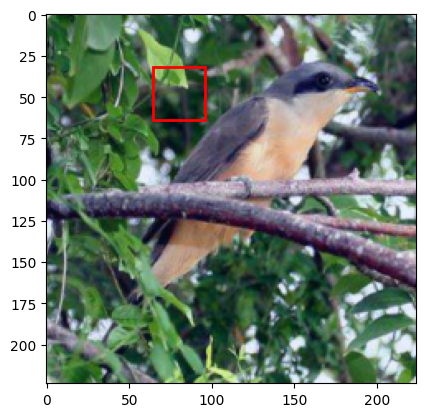

In [8]:
# # brown and white head
# LABEL = 8
# I, BATCH_IDX, IMAGE = class_images[LABEL][0]
# H_IDX, W_IDX = 4, 19
# print('Label', LABEL)
# print('Batch', I)
# print('Within batch', BATCH_IDX)

# background close to rear of head
LABEL = 8
I, BATCH_IDX, IMAGE = class_images[LABEL][0]
H_IDX, W_IDX = 4, 8
print('Label', LABEL)
print('Batch', I)
print('Within batch', BATCH_IDX)

# # duck face
# LABEL = 1
# I, BATCH_IDX, IMAGE = class_images[LABEL][0]
# H_IDX, W_IDX = 4, 15
# print('Label', LABEL)
# print('Batch', I)
# print('Within batch', BATCH_IDX)

# # duck face,left=bottom grass region
# LABEL = 1
# I, BATCH_IDX, IMAGE = class_images[LABEL][0]
# H_IDX, W_IDX = 24, 3
# print('Label', LABEL)
# print('Batch', I)
# print('Within batch', BATCH_IDX)

# stick legs
# LABEL = 1
# I, BATCH_IDX, IMAGE = class_images[LABEL][0]
# H_IDX, W_IDX = 22, 11
# print('Label', LABEL)
# print('Batch', I)
# print('Within batch', BATCH_IDX)

# black head
# LABEL = 3
# I, BATCH_IDX, IMAGE = class_images[LABEL][0]
# H_IDX, W_IDX = 4, 20
# print('Label', LABEL)
# print('Batch', I)
# print('Within batch', BATCH_IDX)

# black tail
# LABEL = 3
# I, BATCH_IDX, IMAGE = class_images[LABEL][0]
# H_IDX, W_IDX = 12, 8
# print('Label', LABEL)
# print('Batch', I)
# print('Within batch', BATCH_IDX)

# black duck head
# LABEL = 4
# I, BATCH_IDX, IMAGE = class_images[LABEL][0]
# H_IDX, W_IDX = 2, 8
# print('Label', LABEL)
# print('Batch', I)
# print('Within batch', BATCH_IDX)

h_coor_min, h_coor_max, w_coor_min, w_coor_max = get_img_coordinates(
                img_size, softmaxes_shape, patchsize, skip, H_IDX, W_IDX
                )

IMAGE = IMAGE.permute(1, 2, 0)  # Convert image to (H, W, C) format
min_val = IMAGE.min()
max_val = IMAGE.max()
IMAGE = (IMAGE - min_val) / (max_val - min_val)

# Plot bounding box with the selected color
plt.imshow(IMAGE)
plt.gca().add_patch(
    plt.Rectangle(
        (w_coor_min, h_coor_min),
        w_coor_max - w_coor_min,
        h_coor_max - h_coor_min,
        fill=False,
        edgecolor='red',
        linewidth=2
    )
)
plt.show()

In [9]:
from pipnet.train import flatten_tensor

img_iter = tqdm(enumerate(projectloader),
                    total=len(projectloader),
                    mininterval=50.,
                    desc='Collecting topk',
                    ncols=0)

BATCH_SIZE = projectloader.batch_size
all_features = torch.empty(0, 768).to(device)
for _i, (xs, ys) in img_iter:
    xs, ys = xs.to(device), ys.to(device)
    
#     # This filter is to check only among the same species, remove this if you wanna consider all species
#     if not ys.item() == LABEL:
#         continue
        
    with torch.no_grad():
        features, pfs, pooled, _ = net(xs, inference=True)
        flattened_features = flatten_tensor(features)
        all_features = torch.cat((all_features, flattened_features))

# normalized_all_features  = F.normalize(all_features, p=2, dim=1)
normalized_all_features  = all_features

In [10]:
print(normalized_all_features.shape)

torch.Size([365040, 768])


In [11]:
top_k = 70 # keep it a multiple of 5

normalized_all_features = normalized_all_features.cpu().numpy()

ref_vector = normalized_all_features[(I*BATCH_SIZE + BATCH_IDX)*(args.wshape ** 2) + H_IDX*args.wshape + W_IDX]
inner_products = np.dot(normalized_all_features, ref_vector)
sorted_indices = np.argsort(inner_products)[::-1]

top_k_indices = sorted_indices[:top_k]
top_k_vectors = normalized_all_features[top_k_indices]
top_k_inner_products = inner_products[top_k_indices]

In [12]:
# maps (i, batch_idx) to (h_idx, w_idx)
nearest_patches_indices = defaultdict(list)

for feature_idx, inner_product in zip(top_k_indices, top_k_inner_products):
    _i = int((feature_idx / (args.wshape ** 2)) / BATCH_SIZE)
    
    _batch_idx = int((feature_idx / (args.wshape ** 2)) % BATCH_SIZE)
    _h_idx = int((feature_idx % (args.wshape ** 2)) / args.wshape)
    _w_idx = int((feature_idx % (args.wshape ** 2)) % args.wshape)
    
    nearest_patches_indices[(_i, _batch_idx)].append((_h_idx, _w_idx, inner_product))
    
    print((_i, _batch_idx, _h_idx, _w_idx, inner_product))

(259, 0, 3, 3, 54.562584)
(240, 0, 3, 8, 53.92818)
(226, 0, 3, 23, 52.463554)
(211, 0, 3, 22, 52.26609)
(259, 0, 3, 2, 52.00023)
(226, 0, 3, 22, 51.69094)
(211, 0, 3, 21, 51.48398)
(240, 0, 3, 9, 50.922333)
(211, 0, 3, 17, 50.802193)
(240, 0, 3, 7, 50.68706)
(259, 0, 3, 4, 50.63893)
(232, 0, 3, 8, 50.360435)
(232, 0, 3, 7, 50.04778)
(238, 0, 3, 22, 50.027153)
(274, 0, 3, 22, 49.5226)
(211, 0, 3, 16, 49.455627)
(211, 0, 3, 23, 49.395313)
(259, 0, 4, 3, 49.37018)
(297, 0, 3, 1, 49.217815)
(282, 0, 3, 2, 49.05841)
(259, 0, 3, 1, 49.016766)
(211, 0, 3, 18, 49.00007)
(282, 0, 3, 1, 48.727425)
(274, 0, 3, 21, 48.610176)
(254, 0, 3, 3, 48.52369)
(271, 0, 3, 8, 48.46707)
(254, 0, 3, 4, 48.446224)
(232, 0, 3, 6, 48.37252)
(232, 0, 3, 9, 48.26461)
(211, 0, 3, 20, 47.99626)
(246, 0, 3, 10, 47.90568)
(297, 0, 3, 3, 47.90062)
(297, 0, 3, 2, 47.78538)
(226, 0, 3, 21, 47.760197)
(229, 0, 3, 3, 47.747543)
(282, 0, 3, 3, 47.705635)
(238, 0, 3, 23, 47.46024)
(226, 0, 3, 24, 47.437836)
(271, 0, 3, 7, 47.

In [13]:
img_iter = tqdm(enumerate(projectloader),
                    total=len(projectloader),
                    mininterval=50.,
                    desc='Collecting topk',
                    ncols=0)

img_list = []
bbox_list = []
for _i, (xs, ys) in img_iter:
    xs, ys = xs.to(device), ys.to(device)
    images, class_labels = xs, ys
    
#     # This filter is to check only among the same species, remove this if you wanna consider all species
#     if not ys.item() == LABEL:
#         continue
        
    for _batch_idx in range(len(class_labels)):
        label = class_labels[_batch_idx].item()
        image = images[_batch_idx]
                
        if (_i, _batch_idx) in nearest_patches_indices:
            image = image.permute(1, 2, 0)  # Convert image to (H, W, C) format
            min_val = image.min()
            max_val = image.max()
            image = (image - min_val) / (max_val - min_val)
            img_list.append(image.cpu().numpy())
            
            bboxes = []
            for _h_idx, _w_idx, inner_product in nearest_patches_indices[(_i, _batch_idx)]:
                h_coor_min, h_coor_max, w_coor_min, w_coor_max = get_img_coordinates(
                    img_size, softmaxes_shape, patchsize, skip, _h_idx, _w_idx
                    )
                bboxes.append((h_coor_min, h_coor_max, w_coor_min, w_coor_max, inner_product))
            bbox_list.append(bboxes)
            
            
print(len(img_list), len(img_list) == len(bbox_list))

22 True


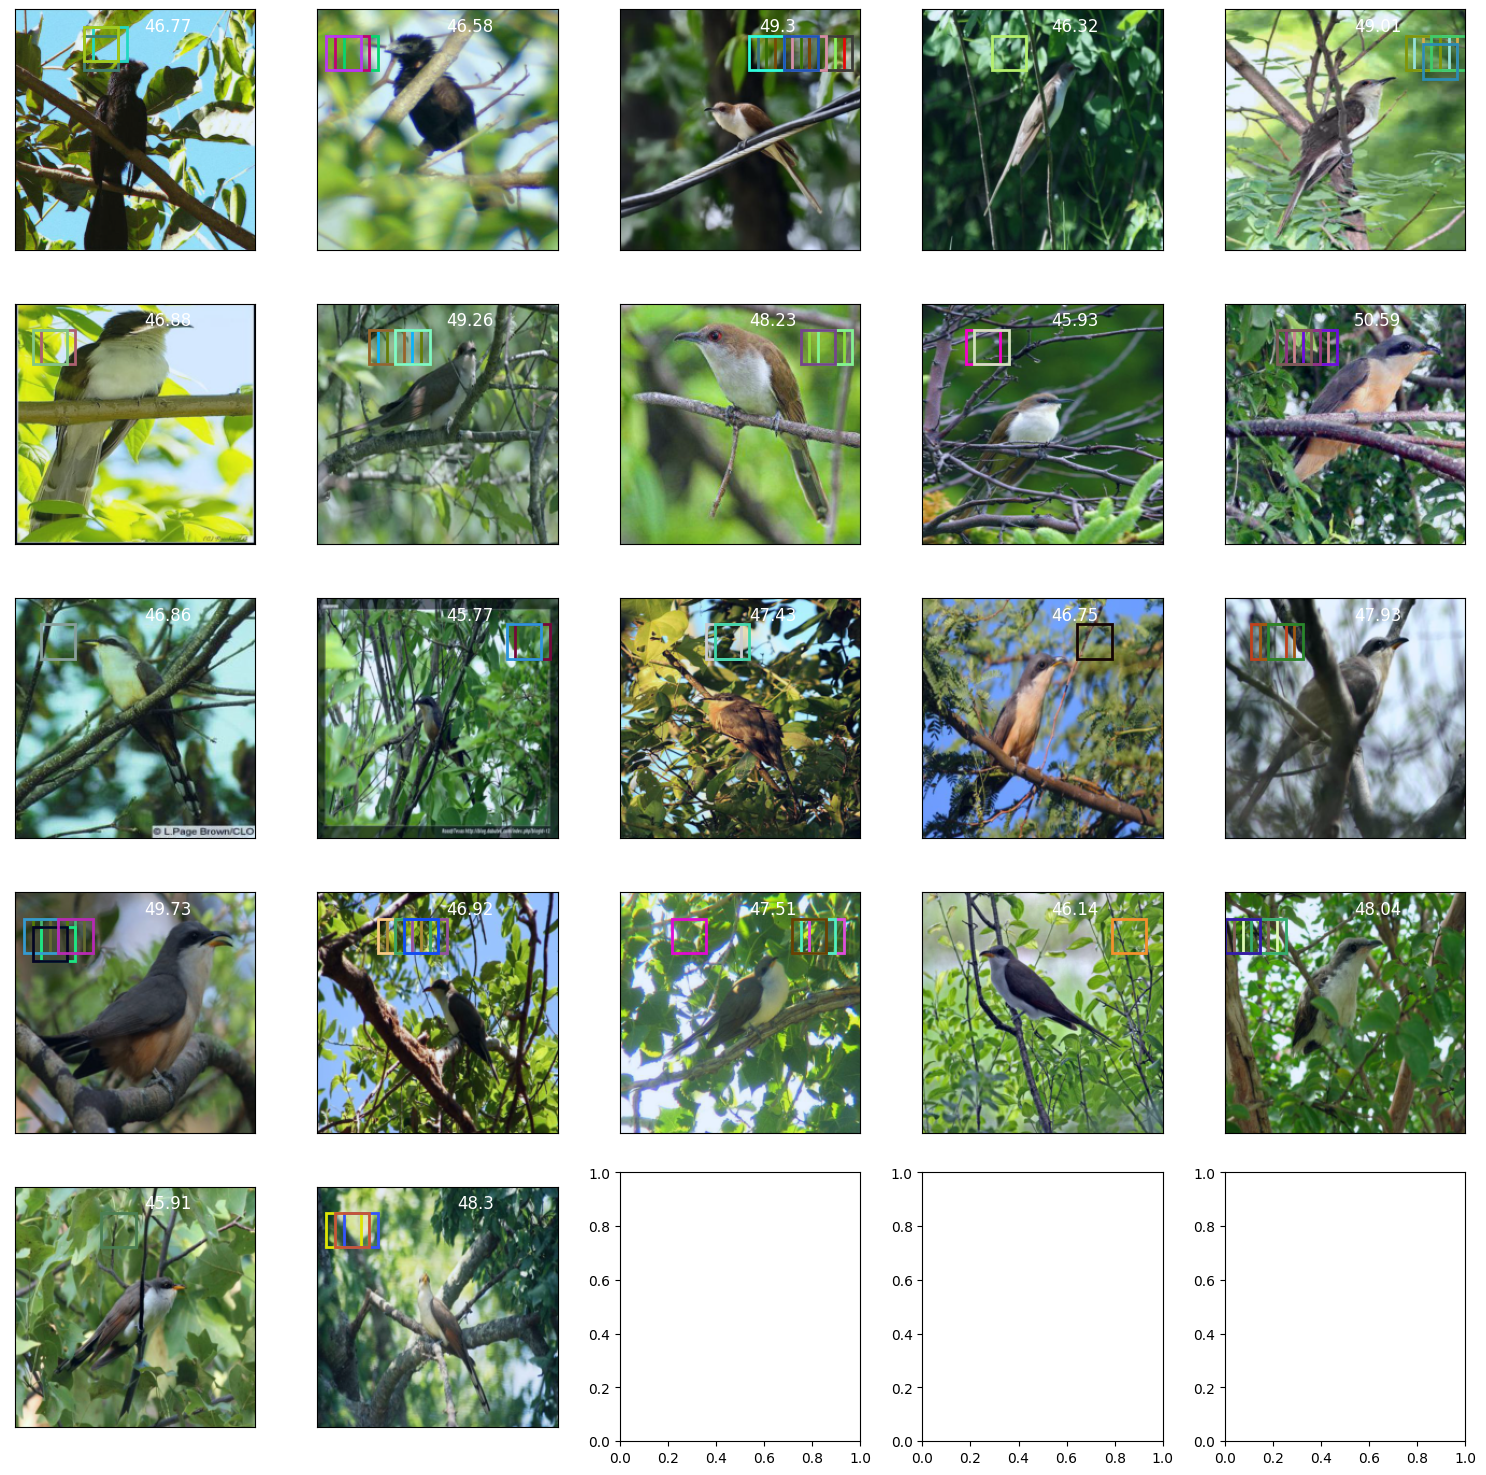

In [14]:
num_images = len(img_list)
num_rows = num_images // 5
if (num_images % 5) != 0:
    num_rows += 1
if num_images < 5:
    num_cols = num_images
else:
    num_cols = 5

# Create a figure and axis for the grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))

for i, (image, bboxes) in enumerate(zip(img_list, bbox_list)):
    row_idx = i // num_cols
    col_idx = i % num_cols
    
    if num_images == 1:
        ax = axes
    elif num_rows > 1:
        ax = axes[row_idx, col_idx]
    else:
        ax = axes[col_idx]

    # Display the image
    ax.imshow(image)
    
    # Plot bounding boxes on the image
    for bbox in bboxes:
        h_coor_min, h_coor_max, w_coor_min, w_coor_max, inner_product = bbox
        rect = plt.Rectangle(
            (w_coor_min, h_coor_min),
            w_coor_max - w_coor_min,
            h_coor_max - h_coor_min,
            fill=False,
            edgecolor=(random.random(), random.random(), random.random()),  # Random color
            linewidth=2
        )
        ax.add_patch(rect)
    
    top_right_description = str(round(np.mean([ip for *_, ip in bboxes]), 2))
    height, width, _ = image.shape
    x_pos = width - 60  # Adjust the value to fit the text inside the image bounds
    y_pos = 20          # Adjust the value according to the desired height
    # Add text on the top-right corner
    ax.text(x_pos, y_pos, top_right_description, fontsize=12, color='white', horizontalalignment='right')


    # Remove axis labels and ticks
    ax.set_xticks([])
    ax.set_yticks([])

# Adjust spacing between subplots
plt.tight_layout()

# Show the grid of images with bounding boxes
plt.show()